<a href="https://colab.research.google.com/github/ramayer/google-colab-examples/blob/main/Siglip2_GradCam_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install -q transformers torch torchvision pillow matplotlib numpy grad-cam



In [10]:

reference_url = 'https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400'
target_url = "https://images.unsplash.com/photo-1450778869180-41d0601e046e?w=400"

reference_url = 'https://cataas.com/cat?type=square&width=512'
target_url = "https://cataas.com/cat?type=square&width=512"

#reference_url = 'https://cataas.com/cat?type=square&width=512'
#target_url = reference_url

Using device: cpu

=== Example: Cat Reference vs Cat+Dog Target ===

Loading images...
Generating GradCAM attention map...
Creating visualization...


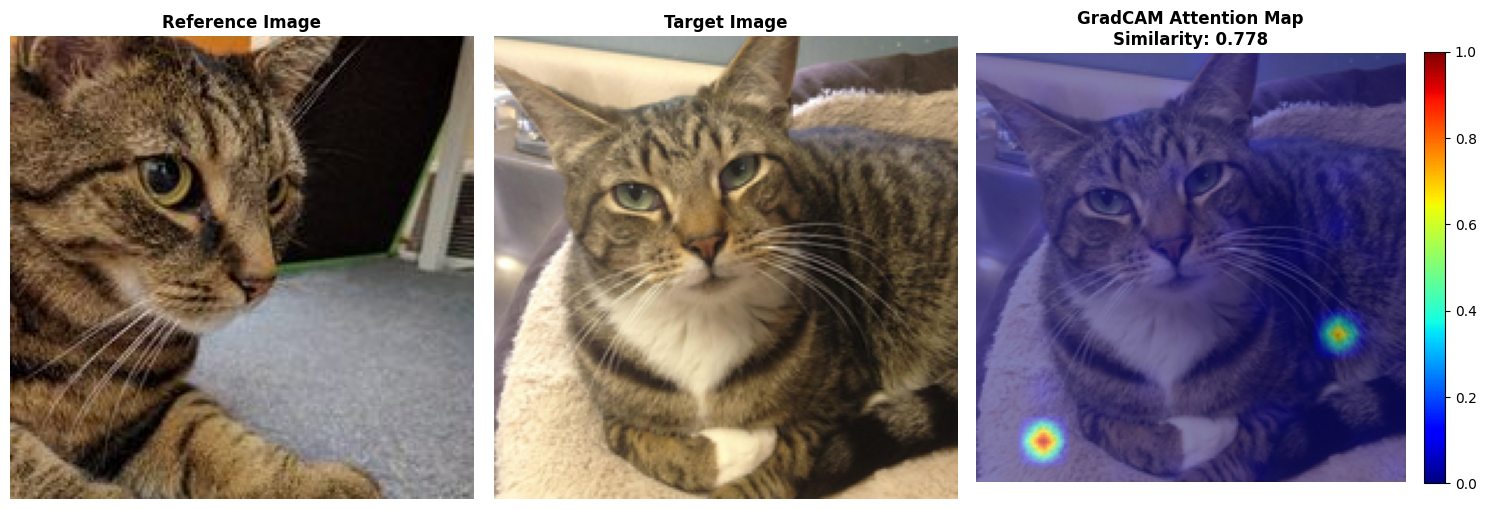


=== Usage Instructions ===
1. Upload your own images to Colab or use URLs
2. Replace reference_url and target_url with your image paths
3. Run the cells to see the GradCAM attention visualization

Example with local files:
  reference_img = load_image('/content/my_reference.jpg')
  target_img = load_image('/content/my_target.jpg')
  attention_map, similarity = get_image_attention_gradcam(reference_img, target_img)
  visualize_attention(reference_img, target_img, attention_map, similarity)

=== Alternative: Compare Multiple Target Images ===


=== Advanced: Try Different Target Layers ===
You can experiment with different layers for GradCAM:
- Early layers: model.vision_model.encoder.layers[0].layer_norm1
- Middle layers: model.vision_model.encoder.layers[12].layer_norm1
- Late layers: model.vision_model.encoder.layers[-1].layer_norm1
Different layers show attention at different levels of abstraction!


In [8]:
# SigLIP-2 Image-to-Image Attention Visualization with GradCAM
# This notebook visualizes which parts of an image SigLIP-2 focuses on
# when comparing it to a reference image using proper GradCAM

# Install required packages
#!pip install -q transformers torch torchvision pillow matplotlib numpy grad-cam

import torch
import torch.nn.functional as F
from transformers import AutoProcessor, AutoModel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load SigLIP-2 model and processor
model_name = "google/siglip-so400m-patch14-384" # unimpressive
model_name = "google/siglip2-large-patch16-256"
#model_name = "google/siglip2-so400m-patch16-256"

processor = AutoProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

def load_image(image_source):
    """Load image from URL or local path"""
    if isinstance(image_source, str):
        if image_source.startswith('http'):
            response = requests.get(image_source)
            image = Image.open(BytesIO(response.content))
        else:
            image = Image.open(image_source)
    else:
        image = image_source
    return image.convert('RGB')

class SigLIPImageWrapper(torch.nn.Module):
    """Wrapper to make SigLIP compatible with GradCAM"""
    def __init__(self, model, reference_features):
        super().__init__()
        self.model = model
        self.reference_features = reference_features

    def forward(self, x):
        # Get target image features using the vision model
        vision_outputs = self.model.vision_model(x)
        target_features = vision_outputs.pooler_output

        # Apply the vision model's projection head if it exists
        if hasattr(self.model, 'vision_projection'):
            target_features = self.model.vision_projection(target_features)

        # Normalize
        target_features = F.normalize(target_features, dim=-1)

        # Compute similarity with reference
        similarity = (self.reference_features * target_features).sum(dim=-1)

        return similarity.unsqueeze(0)

def get_image_attention_gradcam(reference_image, target_image):
    """
    Generate GradCAM attention heatmap showing which parts of target_image
    are most similar to reference_image
    """
    # Process reference image to get its features
    ref_inputs = processor(images=reference_image, return_tensors="pt").to(device)

    with torch.no_grad():
        ref_outputs = model.get_image_features(**ref_inputs)
        ref_features = F.normalize(ref_outputs, dim=-1)

    # Process target image
    target_inputs = processor(images=target_image, return_tensors="pt")
    target_tensor = target_inputs['pixel_values'].to(device)

    # Create wrapper model for GradCAM
    wrapped_model = SigLIPImageWrapper(model, ref_features)

    # Define reshape transform for vision transformers
    def reshape_transform(tensor, height=None, width=None):
        """Reshape transformer output [B, N+1, C] to [B, C, H, W] for GradCAM"""
        # Remove CLS token if present (first token)
        if tensor.size(1) == 577:  # 24x24 + 1 CLS token for 384x384 images
            tensor = tensor[:, 1:, :]

        # Get dimensions
        B, N, C = tensor.shape
        H = W = int(np.sqrt(N))

        # Reshape to [B, C, H, W]
        result = tensor.reshape(B, H, W, C).permute(0, 3, 1, 2)
        return result

    # Target the last transformer block
    target_layers = [model.vision_model.encoder.layers[-1]]

    # Create GradCAM object with reshape transform
    cam = GradCAM(model=wrapped_model,
                  target_layers=target_layers,
                  reshape_transform=reshape_transform)

    # Generate CAM
    grayscale_cam = cam(input_tensor=target_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :]

    # Get similarity score
    with torch.no_grad():
        target_features = model.get_image_features(pixel_values=target_tensor)
        target_features = F.normalize(target_features, dim=-1)
        similarity = (ref_features * target_features).sum().item()

    return grayscale_cam, similarity

def visualize_attention(reference_image, target_image, attention_map, similarity_score):
    """Visualize the GradCAM attention heatmap overlaid on the target image"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Reference image
    axes[0].imshow(reference_image)
    axes[0].set_title("Reference Image", fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Target image
    axes[1].imshow(target_image)
    axes[1].set_title("Target Image", fontsize=12, fontweight='bold')
    axes[1].axis('off')

    # Attention heatmap overlay
    # Convert target image to numpy array normalized to [0, 1]
    target_array = np.array(target_image).astype(np.float32) / 255.0

    # Resize attention map to match image size
    from scipy.ndimage import zoom
    zoom_factors = (target_array.shape[0] / attention_map.shape[0],
                    target_array.shape[1] / attention_map.shape[1])
    attention_resized = zoom(attention_map, zoom_factors, order=1)

    # Create visualization
    visualization = show_cam_on_image(target_array, attention_resized, use_rgb=True)

    axes[2].imshow(visualization)
    axes[2].set_title(f"GradCAM Attention Map\nSimilarity: {similarity_score:.3f}",
                     fontsize=12, fontweight='bold')
    axes[2].axis('off')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    plt.colorbar(sm, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# Example usage with sample images
print("\n=== Example: Cat Reference vs Cat+Dog Target ===\n")

# You can replace these URLs with your own images
#reference_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/481px-Cat03.jpg"
#target_url = "https://images.unsplash.com/photo-1450778869180-41d0601e046e?w=600"

# Load images
print("Loading images...")
reference_img = load_image(reference_url)
target_img = load_image(target_url)

# Generate GradCAM attention map
print("Generating GradCAM attention map...")
attention_map, similarity = get_image_attention_gradcam(reference_img, target_img)

# Visualize results
print("Creating visualization...")
visualize_attention(reference_img, target_img, attention_map, similarity)

print("\n=== Usage Instructions ===")
print("1. Upload your own images to Colab or use URLs")
print("2. Replace reference_url and target_url with your image paths")
print("3. Run the cells to see the GradCAM attention visualization")
print("\nExample with local files:")
print("  reference_img = load_image('/content/my_reference.jpg')")
print("  target_img = load_image('/content/my_target.jpg')")
print("  attention_map, similarity = get_image_attention_gradcam(reference_img, target_img)")
print("  visualize_attention(reference_img, target_img, attention_map, similarity)")

print("\n=== Alternative: Compare Multiple Target Images ===\n")

def compare_multiple_targets(reference_image, target_images, titles=None):
    """Compare reference image against multiple target images using GradCAM"""
    n_targets = len(target_images)
    fig, axes = plt.subplots(2, n_targets + 1, figsize=(5 * (n_targets + 1), 10))

    if n_targets == 1:
        axes = axes.reshape(2, -1)

    # Show reference image
    axes[0, 0].imshow(reference_image)
    axes[0, 0].set_title("Reference Image", fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')

    for idx, target_img in enumerate(target_images):
        # Generate GradCAM attention map
        attention_map, similarity = get_image_attention_gradcam(reference_image, target_img)

        # Show target image
        axes[0, idx + 1].imshow(target_img)
        title = titles[idx] if titles else f"Target {idx + 1}"
        axes[0, idx + 1].set_title(f"{title}\nSimilarity: {similarity:.3f}",
                                    fontsize=12, fontweight='bold')
        axes[0, idx + 1].axis('off')

        # Show GradCAM overlay
        target_array = np.array(target_img).astype(np.float32) / 255.0

        from scipy.ndimage import zoom
        zoom_factors = (target_array.shape[0] / attention_map.shape[0],
                       target_array.shape[1] / attention_map.shape[1])
        attention_resized = zoom(attention_map, zoom_factors, order=1)

        visualization = show_cam_on_image(target_array, attention_resized, use_rgb=True)
        axes[1, idx + 1].imshow(visualization)
        axes[1, idx + 1].set_title("GradCAM Attention", fontsize=12, fontweight='bold')
        axes[1, idx + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example: Compare cat reference against multiple targets
# Uncomment and modify URLs as needed
# target_images = [
#     load_image("url_to_image1.jpg"),
#     load_image("url_to_image2.jpg"),
#     load_image("url_to_image3.jpg")
# ]
# compare_multiple_targets(reference_img, target_images,
#                         titles=["Dog+Cat", "Just Cat", "Just Dog"])

print("\n=== Advanced: Try Different Target Layers ===")
print("You can experiment with different layers for GradCAM:")
print("- Early layers: model.vision_model.encoder.layers[0].layer_norm1")
print("- Middle layers: model.vision_model.encoder.layers[12].layer_norm1")
print("- Late layers: model.vision_model.encoder.layers[-1].layer_norm1")
print("Different layers show attention at different levels of abstraction!")

Using device: cpu
Loaded model: google/siglip-so400m-patch14-384

=== Example: Comparing Attention Methods ===

Loading images...
Computing patch-based attention...
Computing gradient-based attention...
Creating visualization...


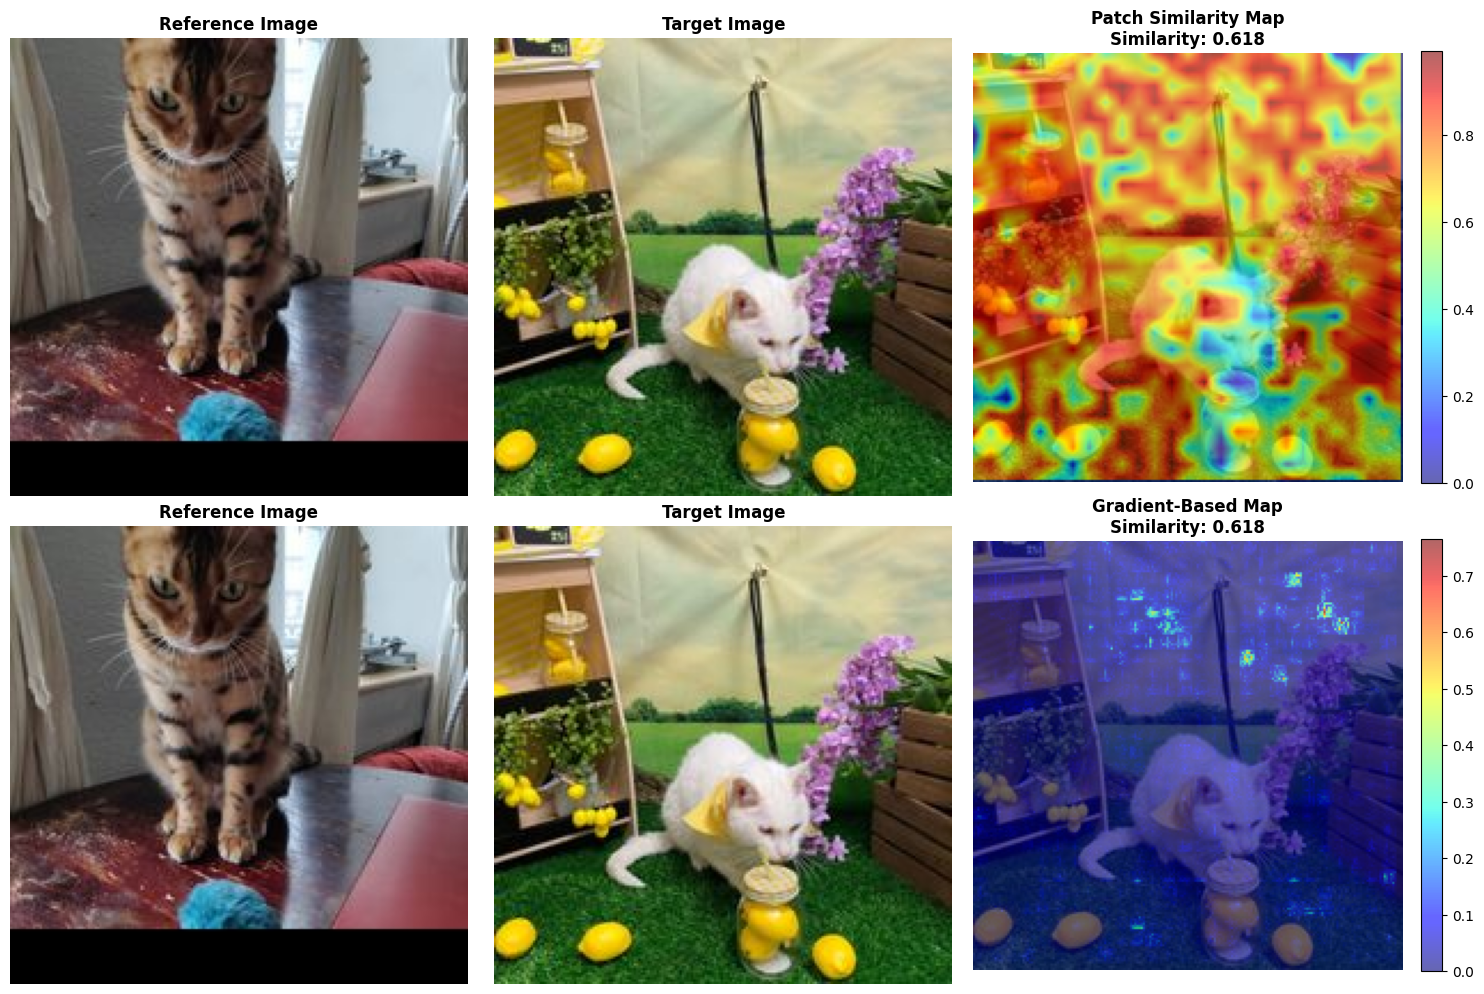


Interpretation:
- Patch Similarity: Shows which patches of target image are most similar to reference patches
- Gradient-Based: Shows which pixels most influence the similarity score
- Brighter areas (red/yellow) = higher relevance to reference image

=== Simple Single Visualization Function ===

Usage examples:
  patch_attn, sim = simple_visualize(ref_img, target_img, method='patch')
  grad_attn, sim = simple_visualize(ref_img, target_img, method='gradient')


In [12]:
# SigLIP-2 Image-to-Image Attention Visualization
# Using attention weights to visualize which parts of target image
# are most relevant when comparing to reference image

# Install required packages
!pip install -q transformers torch torchvision pillow matplotlib numpy scipy

import torch
import torch.nn.functional as F
from transformers import AutoProcessor, AutoModel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
from scipy.ndimage import zoom

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load SigLIP-2 model and processor
model_name = "google/siglip-so400m-patch14-384"
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True).to(device)
model.eval()

print(f"Loaded model: {model_name}")

def load_image(image_source):
    """Load image from URL or local path"""
    if isinstance(image_source, str):
        if image_source.startswith('http'):
            response = requests.get(image_source)
            image = Image.open(BytesIO(response.content))
        else:
            image = Image.open(image_source)
    else:
        image = image_source
    return image.convert('RGB')

def get_attention_based_similarity_map(reference_image, target_image):
    """
    Generate attention-based visualization showing which patches in target_image
    are most similar to reference_image patches

    This uses patch-level similarity rather than gradients
    """
    # Process both images
    ref_inputs = processor(images=reference_image, return_tensors="pt").to(device)
    target_inputs = processor(images=target_image, return_tensors="pt").to(device)

    with torch.no_grad():
        # Get full vision model outputs with hidden states
        ref_vision_out = model.vision_model(
            pixel_values=ref_inputs['pixel_values'],
            output_hidden_states=True
        )
        target_vision_out = model.vision_model(
            pixel_values=target_inputs['pixel_values'],
            output_hidden_states=True
        )

        # Get the last layer's hidden states (before pooling)
        # Shape: [batch, num_patches, hidden_dim]
        ref_patches = ref_vision_out.last_hidden_state
        target_patches = target_vision_out.last_hidden_state

        # Remove CLS token if present (first token)
        if ref_patches.shape[1] == 577:  # 24x24 patches + 1 CLS for 384x384
            ref_patches = ref_patches[:, 1:, :]
            target_patches = target_patches[:, 1:, :]

        # Normalize patch embeddings
        ref_patches_norm = F.normalize(ref_patches, dim=-1)
        target_patches_norm = F.normalize(target_patches, dim=-1)

        # Compute patch-to-patch similarity matrix
        # Shape: [ref_patches, target_patches]
        similarity_matrix = torch.matmul(
            ref_patches_norm[0],  # [num_ref_patches, dim]
            target_patches_norm[0].transpose(0, 1)  # [dim, num_target_patches]
        )

        # Average similarity across all reference patches for each target patch
        # This gives us "how similar is each target patch to the reference image overall"
        target_relevance = similarity_matrix.mean(dim=0).cpu().numpy()

        # Also get overall image-level similarity for comparison
        ref_features = model.get_image_features(**ref_inputs)
        target_features = model.get_image_features(**target_inputs)
        ref_features_norm = F.normalize(ref_features, dim=-1)
        target_features_norm = F.normalize(target_features, dim=-1)
        overall_similarity = (ref_features_norm * target_features_norm).sum().item()

    # Reshape to 2D grid
    grid_size = int(np.sqrt(len(target_relevance)))
    attention_map = target_relevance.reshape(grid_size, grid_size)

    # Normalize to [0, 1]
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8)

    return attention_map, overall_similarity

def get_gradient_based_attention(reference_image, target_image):
    """
    Alternative: Use gradients of similarity w.r.t. target image pixels
    This is simpler and shows which pixels affect similarity most
    """
    # Process images
    ref_inputs = processor(images=reference_image, return_tensors="pt").to(device)
    target_inputs = processor(images=target_image, return_tensors="pt").to(device)

    # Get reference features (no gradients needed)
    with torch.no_grad():
        ref_features = model.get_image_features(**ref_inputs)
        ref_features_norm = F.normalize(ref_features, dim=-1)

    # Get target features with gradients
    target_inputs['pixel_values'].requires_grad = True
    target_features = model.get_image_features(**target_inputs)
    target_features_norm = F.normalize(target_features, dim=-1)

    # Compute similarity
    similarity = (ref_features_norm * target_features_norm).sum()

    # Backpropagate
    similarity.backward()

    # Get gradients and create attention map
    gradients = target_inputs['pixel_values'].grad.data
    attention = gradients.abs().mean(dim=1).squeeze().cpu().numpy()

    # Normalize
    attention = (attention - attention.min()) / (attention.max() - attention.min() + 1e-8)

    return attention, similarity.item()

def visualize_comparison(reference_image, target_image, patch_attention, grad_attention, similarity):
    """Compare both attention visualization methods"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Top row: Patch-based attention
    axes[0, 0].imshow(reference_image)
    axes[0, 0].set_title("Reference Image", fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(target_image)
    axes[0, 1].set_title("Target Image", fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')

    # Patch-based attention overlay
    target_array = np.array(target_image).astype(np.float32) / 255.0
    zoom_factors = (target_array.shape[0] / patch_attention.shape[0],
                    target_array.shape[1] / patch_attention.shape[1])
    patch_attention_resized = zoom(patch_attention, zoom_factors, order=1)

    axes[0, 2].imshow(target_array)
    im1 = axes[0, 2].imshow(patch_attention_resized, cmap='jet', alpha=0.6)
    axes[0, 2].set_title(f"Patch Similarity Map\nSimilarity: {similarity:.3f}",
                        fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    plt.colorbar(im1, ax=axes[0, 2], fraction=0.046, pad=0.04)

    # Bottom row: Gradient-based attention
    axes[1, 0].imshow(reference_image)
    axes[1, 0].set_title("Reference Image", fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(target_image)
    axes[1, 1].set_title("Target Image", fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')

    # Gradient-based attention overlay
    zoom_factors = (target_array.shape[0] / grad_attention.shape[0],
                    target_array.shape[1] / grad_attention.shape[1])
    grad_attention_resized = zoom(grad_attention, zoom_factors, order=1)

    axes[1, 2].imshow(target_array)
    im2 = axes[1, 2].imshow(grad_attention_resized, cmap='jet', alpha=0.6)
    axes[1, 2].set_title(f"Gradient-Based Map\nSimilarity: {similarity:.3f}",
                        fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')
    plt.colorbar(im2, ax=axes[1, 2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    print("\nInterpretation:")
    print("- Patch Similarity: Shows which patches of target image are most similar to reference patches")
    print("- Gradient-Based: Shows which pixels most influence the similarity score")
    print("- Brighter areas (red/yellow) = higher relevance to reference image")

# Example usage
print("\n=== Example: Comparing Attention Methods ===\n")

# Example URLs (replace with your own)
#reference_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/481px-Cat03.jpg"
#target_url = "https://images.unsplash.com/photo-1450778869180-41d0601e046e?w=600"

print("Loading images...")
reference_img = load_image(reference_url)
target_img = load_image(target_url)

print("Computing patch-based attention...")
patch_attn, similarity1 = get_attention_based_similarity_map(reference_img, target_img)

print("Computing gradient-based attention...")
grad_attn, similarity2 = get_gradient_based_attention(reference_img, target_img)

print("Creating visualization...")
visualize_comparison(reference_img, target_img, patch_attn, grad_attn, similarity1)

print("\n=== Simple Single Visualization Function ===\n")

def simple_visualize(reference_image, target_image, method='patch'):
    """
    Simplified function for quick visualization
    method: 'patch' or 'gradient'
    """
    if method == 'patch':
        attention, similarity = get_attention_based_similarity_map(reference_image, target_image)
        title_suffix = "Patch Similarity"
    else:
        attention, similarity = get_gradient_based_attention(reference_image, target_image)
        title_suffix = "Gradient-Based"

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(reference_image)
    axes[0].set_title("Reference", fontsize=12, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(target_image)
    axes[1].set_title("Target", fontsize=12, fontweight='bold')
    axes[1].axis('off')

    target_array = np.array(target_image).astype(np.float32) / 255.0
    zoom_factors = (target_array.shape[0] / attention.shape[0],
                    target_array.shape[1] / attention.shape[1])
    attention_resized = zoom(attention, zoom_factors, order=1)

    axes[2].imshow(target_array)
    im = axes[2].imshow(attention_resized, cmap='jet', alpha=0.6)
    axes[2].set_title(f"{title_suffix}\nSimilarity: {similarity:.3f}",
                     fontsize=12, fontweight='bold')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    return attention, similarity

print("Usage examples:")
print("  patch_attn, sim = simple_visualize(ref_img, target_img, method='patch')")
print("  grad_attn, sim = simple_visualize(ref_img, target_img, method='gradient')")

In [13]:
# SigLIP-2 Semantic Image-to-Image Attention Visualization
# Shows which parts of target image are semantically relevant to reference image
# (e.g., highlights cats in target when reference shows a cat, regardless of position)

# Install required packages
!pip install -q transformers torch torchvision pillow matplotlib numpy scipy

import torch
import torch.nn.functional as F
from transformers import AutoProcessor, AutoModel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
from scipy.ndimage import zoom

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load SigLIP-2 model and processor
model_name = "google/siglip-so400m-patch14-384"
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

print(f"Loaded model: {model_name}")

def load_image(image_source):
    """Load image from URL or local path"""
    if isinstance(image_source, str):
        if image_source.startswith('http'):
            response = requests.get(image_source)
            image = Image.open(BytesIO(response.content))
        else:
            image = Image.open(image_source)
    else:
        image = image_source
    return image.convert('RGB')

def get_semantic_attention_map(reference_image, target_image):
    """
    Generate semantic attention map showing which parts of target_image
    are semantically similar to the reference_image as a whole.

    Uses the global reference embedding to query target patches.
    """
    # Process both images
    ref_inputs = processor(images=reference_image, return_tensors="pt").to(device)
    target_inputs = processor(images=target_image, return_tensors="pt").to(device)

    with torch.no_grad():
        # Get GLOBAL reference embedding (what the reference image "means")
        ref_features = model.get_image_features(**ref_inputs)
        ref_features_norm = F.normalize(ref_features, dim=-1)

        # Get LOCAL target patch embeddings
        target_vision_out = model.vision_model(
            pixel_values=target_inputs['pixel_values'],
            output_hidden_states=True
        )

        # Get patch-level features from last hidden state
        target_patches = target_vision_out.last_hidden_state  # [1, num_patches, hidden_dim]

        # Remove CLS token if present
        if target_patches.shape[1] == 577:  # 24x24 patches + 1 CLS
            target_patches = target_patches[:, 1:, :]

        # Apply the same projection that get_image_features uses
        # to ensure embeddings are in the same space
        if hasattr(model, 'vision_projection'):
            target_patches_projected = model.vision_projection(target_patches)
        else:
            target_patches_projected = target_patches

        # Normalize target patches
        target_patches_norm = F.normalize(target_patches_projected, dim=-1)

        # Compute similarity between global reference and each target patch
        # This answers: "how similar is each target patch to the overall reference concept?"
        patch_similarities = torch.matmul(
            target_patches_norm[0],  # [num_patches, dim]
            ref_features_norm[0].unsqueeze(-1)  # [dim, 1]
        ).squeeze(-1)  # [num_patches]

        patch_similarities = patch_similarities.cpu().numpy()

        # Also compute overall image similarity for reference
        target_features = model.get_image_features(**target_inputs)
        target_features_norm = F.normalize(target_features, dim=-1)
        overall_similarity = (ref_features_norm * target_features_norm).sum().item()

    # Reshape to 2D spatial grid
    grid_size = int(np.sqrt(len(patch_similarities)))
    attention_map = patch_similarities.reshape(grid_size, grid_size)

    # Normalize to [0, 1] for visualization
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8)

    return attention_map, overall_similarity, patch_similarities

def visualize_semantic_attention(reference_image, target_image, attention_map, similarity):
    """Visualize semantic attention heatmap"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Reference image
    axes[0].imshow(reference_image)
    axes[0].set_title("Reference Image\n(What concept to look for)",
                     fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Target image
    axes[1].imshow(target_image)
    axes[1].set_title("Target Image\n(Where to find it)",
                     fontsize=12, fontweight='bold')
    axes[1].axis('off')

    # Semantic attention overlay
    target_array = np.array(target_image).astype(np.float32) / 255.0
    zoom_factors = (target_array.shape[0] / attention_map.shape[0],
                    target_array.shape[1] / attention_map.shape[1])
    attention_resized = zoom(attention_map, zoom_factors, order=1)

    axes[2].imshow(target_array)
    im = axes[2].imshow(attention_resized, cmap='jet', alpha=0.6)
    axes[2].set_title(f"Semantic Attention\nSimilarity: {similarity:.3f}",
                     fontsize=12, fontweight='bold')
    axes[2].axis('off')

    cbar = plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    cbar.set_label('Relevance to Reference', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

    print("\nInterpretation:")
    print("- Bright areas (red/yellow) = parts of target semantically similar to reference")
    print("- Dark areas (blue/purple) = parts of target dissimilar to reference")
    print("- This highlights semantic content, NOT spatial correspondence")
    print(f"- Overall similarity: {similarity:.3f} (higher = more similar images)")

def compare_multiple_targets(reference_image, target_images, titles=None):
    """Compare reference against multiple targets"""
    n_targets = len(target_images)
    fig, axes = plt.subplots(2, n_targets + 1, figsize=(5 * (n_targets + 1), 10))

    if n_targets == 1:
        axes = axes.reshape(2, -1)

    # Show reference
    axes[0, 0].imshow(reference_image)
    axes[0, 0].set_title("Reference Image", fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    axes[1, 0].text(0.5, 0.5, "Looking for\ncontent similar\nto this",
                    ha='center', va='center', fontsize=14,
                    transform=axes[1, 0].transAxes)
    axes[1, 0].axis('off')

    for idx, target_img in enumerate(target_images):
        attention_map, similarity, _ = get_semantic_attention_map(reference_image, target_img)

        # Show target
        axes[0, idx + 1].imshow(target_img)
        title = titles[idx] if titles else f"Target {idx + 1}"
        axes[0, idx + 1].set_title(f"{title}\nSimilarity: {similarity:.3f}",
                                    fontsize=12, fontweight='bold')
        axes[0, idx + 1].axis('off')

        # Show attention
        target_array = np.array(target_img).astype(np.float32) / 255.0
        zoom_factors = (target_array.shape[0] / attention_map.shape[0],
                       target_array.shape[1] / attention_map.shape[1])
        attention_resized = zoom(attention_map, zoom_factors, order=1)

        axes[1, idx + 1].imshow(target_array)
        axes[1, idx + 1].imshow(attention_resized, cmap='jet', alpha=0.6)
        axes[1, idx + 1].set_title("Semantic Attention", fontsize=12, fontweight='bold')
        axes[1, idx + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
print("\n=== Example: Cat Reference vs Mixed Images ===\n")

# Example: Show semantic matching
reference_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/481px-Cat03.jpg"
target_url = "https://images.unsplash.com/photo-1450778869180-41d0601e046e?w=600"
#reference_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/481px-Cat03.jpg"
#target_url = "https://images.unsplash.com/photo-1450778869180-41d0601e046e?w=600"

reference_url = 'https://cataas.com/cat?type=square&width=512'
target_url = "https://cataas.com/cat?type=square&width=512"

print("Loading images...")
reference_img = load_image(reference_url)
target_img = load_image(target_url)

print("Computing semantic attention map...")
print("This shows which parts of the target are semantically similar to the reference")
print("(e.g., if reference is a cat, it should highlight cats in target)")
attention_map, similarity, raw_scores = get_semantic_attention_map(reference_img, target_img)

print("\nCreating visualization...")
visualize_semantic_attention(reference_img, target_img, attention_map, similarity)

print("\n" + "="*70)
print("UNDERSTANDING THE METHOD")
print("="*70)
print("""
This approach:
1. Encodes the reference image into a single global embedding
   (captures the overall semantic meaning: "this is a cat")

2. Encodes the target image into patch-level embeddings
   (each patch represents a small region of the target)

3. Compares the global reference embedding to each target patch
   (asks: "which patches look like the reference concept?")

4. Creates a heatmap showing semantic relevance
   (bright = contains similar semantic content to reference)

Example: If your reference is "cat playing with toy in lower-left"
- The model learns "cat + toy + playful interaction"
- When shown a target with a cat in the upper-right
- It highlights that cat, regardless of position
- Because it's semantically similar (both are cats in playful contexts)

This is different from spatial matching - it's concept matching!
""")

print("\n=== Try Your Own Images ===\n")
print("# Upload images and run:")
print("ref_img = load_image('/content/my_cat.jpg')")
print("target_img = load_image('/content/scene_with_cat_and_dog.jpg')")
print("attn, sim, _ = get_semantic_attention_map(ref_img, target_img)")
print("visualize_semantic_attention(ref_img, target_img, attn, sim)")
print()
print("# Or compare multiple targets:")
print("targets = [load_image(url1), load_image(url2), load_image(url3)]")
print("compare_multiple_targets

SyntaxError: unterminated string literal (detected at line 244) (ipython-input-1664832824.py, line 244)

Using device: cpu
Loaded model: google/siglip-so400m-patch14-384

=== Example: Cat Reference vs Mixed Images ===

Loading images...
Computing semantic attention map...
This shows which parts of the target are semantically similar to the reference
(e.g., if reference is a cat, it should highlight cats in target)

Creating visualization...


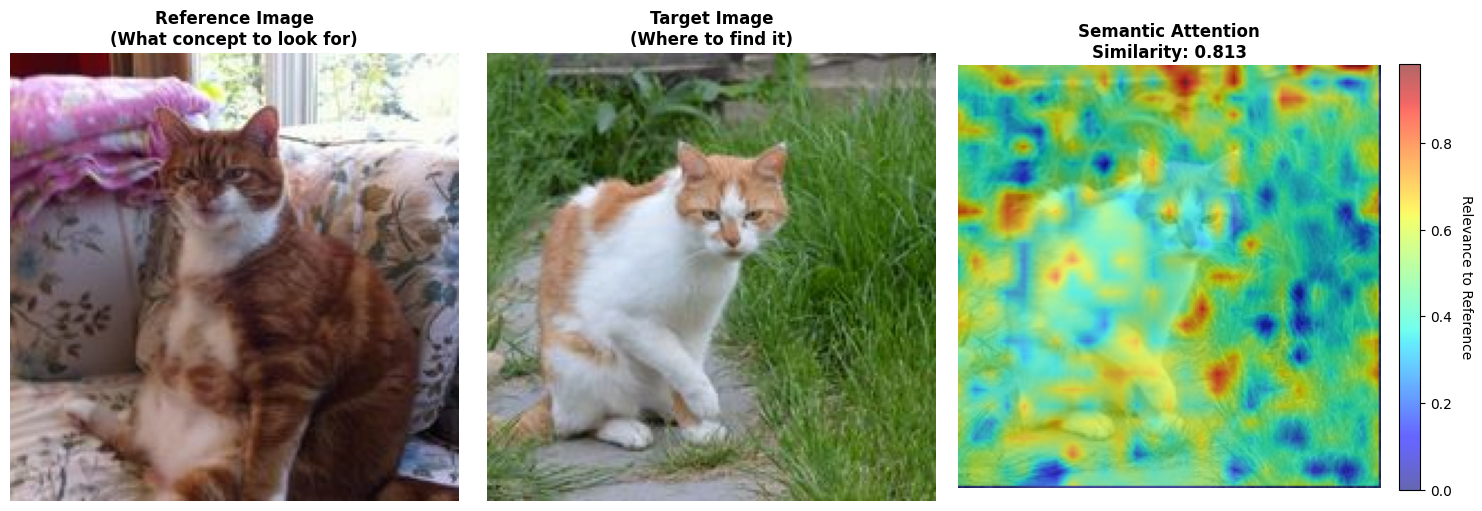


Interpretation:
- Bright areas (red/yellow) = parts of target semantically similar to reference
- Dark areas (blue/purple) = parts of target dissimilar to reference
- This highlights semantic content, NOT spatial correspondence
- Overall similarity: 0.813 (higher = more similar images)

UNDERSTANDING THE METHOD & EMBEDDING SPACES

This approach addresses a critical issue with vision-language models:

EMBEDDING SPACE ALIGNMENT:
- SigLIP has TWO embedding spaces:
  1. Vision-only space (internal to vision_model)
  2. Joint vision-language space (after vision_projection)

- get_image_features() returns embeddings in the JOINT space
- vision_model outputs are in the VISION-ONLY space
- These are NOT comparable without projection!

OUR SOLUTION:
1. Get reference embedding: Use get_image_features() → joint space
2. Get target patches: Extract from vision_model.last_hidden_state
3. PROJECT target patches: Apply vision_projection to each patch
4. NOW we can compare: Both are in the joint visi

In [15]:
# SigLIP-2 Semantic Image-to-Image Attention Visualization
# Shows which parts of target image are semantically relevant to reference image
# (e.g., highlights cats in target when reference shows a cat, regardless of position)

# Install required packages
!pip install -q transformers torch torchvision pillow matplotlib numpy scipy

import torch
import torch.nn.functional as F
from transformers import AutoProcessor, AutoModel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
from scipy.ndimage import zoom

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load SigLIP-2 model and processor
model_name = "google/siglip-so400m-patch14-384"
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

print(f"Loaded model: {model_name}")

def load_image(image_source):
    """Load image from URL or local path"""
    if isinstance(image_source, str):
        if image_source.startswith('http'):
            response = requests.get(image_source)
            image = Image.open(BytesIO(response.content))
        else:
            image = Image.open(image_source)
    else:
        image = image_source
    return image.convert('RGB')

def get_semantic_attention_map(reference_image, target_image):
    """
    Generate semantic attention map showing which parts of target_image
    are semantically similar to the reference_image as a whole.

    Uses the global reference embedding to query target patches.
    """
    # Process both images
    ref_inputs = processor(images=reference_image, return_tensors="pt").to(device)
    target_inputs = processor(images=target_image, return_tensors="pt").to(device)

    with torch.no_grad():
        # Get GLOBAL reference embedding (what the reference image "means")
        ref_features = model.get_image_features(**ref_inputs)
        ref_features_norm = F.normalize(ref_features, dim=-1)

        # Get LOCAL target patch embeddings
        # We need to extract patches in the SAME embedding space as the global reference
        target_vision_out = model.vision_model(
            pixel_values=target_inputs['pixel_values'],
            output_hidden_states=True
        )

        # Get the pooler output which is what gets projected
        target_pooled = target_vision_out.pooler_output  # [1, hidden_dim]

        # But we also need patch-level features
        # Get the last hidden state before pooling
        target_patches = target_vision_out.last_hidden_state  # [1, num_patches+1, hidden_dim]

        # Remove CLS token if present (first token)
        if target_patches.shape[1] == 577:  # 24x24 patches + 1 CLS
            target_patches = target_patches[:, 1:, :]  # Now [1, 576, hidden_dim]

        # CRITICAL: Apply vision_projection to each patch independently
        # This puts patches in the same joint embedding space as the global reference
        if hasattr(model, 'vision_projection'):
            # Reshape to apply projection: [1, 576, hidden_dim] -> [576, hidden_dim]
            B, N, C = target_patches.shape
            target_patches_flat = target_patches.reshape(B * N, C)
            target_patches_projected = model.vision_projection(target_patches_flat)
            # Reshape back: [576, output_dim] -> [1, 576, output_dim]
            target_patches_projected = target_patches_projected.reshape(B, N, -1)
        else:
            target_patches_projected = target_patches

        # Normalize target patches (now in joint vision-language space)
        target_patches_norm = F.normalize(target_patches_projected, dim=-1)

        # Compute similarity between global reference and each target patch
        # This answers: "how similar is each target patch to the overall reference concept?"
        patch_similarities = torch.matmul(
            target_patches_norm[0],  # [num_patches, dim]
            ref_features_norm[0].unsqueeze(-1)  # [dim, 1]
        ).squeeze(-1)  # [num_patches]

        patch_similarities = patch_similarities.cpu().numpy()

        # Also compute overall image similarity for reference
        target_features = model.get_image_features(**target_inputs)
        target_features_norm = F.normalize(target_features, dim=-1)
        overall_similarity = (ref_features_norm * target_features_norm).sum().item()

    # Reshape to 2D spatial grid
    grid_size = int(np.sqrt(len(patch_similarities)))
    attention_map = patch_similarities.reshape(grid_size, grid_size)

    # Normalize to [0, 1] for visualization
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8)

    return attention_map, overall_similarity, patch_similarities

def visualize_semantic_attention(reference_image, target_image, attention_map, similarity):
    """Visualize semantic attention heatmap"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Reference image
    axes[0].imshow(reference_image)
    axes[0].set_title("Reference Image\n(What concept to look for)",
                     fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Target image
    axes[1].imshow(target_image)
    axes[1].set_title("Target Image\n(Where to find it)",
                     fontsize=12, fontweight='bold')
    axes[1].axis('off')

    # Semantic attention overlay
    target_array = np.array(target_image).astype(np.float32) / 255.0
    zoom_factors = (target_array.shape[0] / attention_map.shape[0],
                    target_array.shape[1] / attention_map.shape[1])
    attention_resized = zoom(attention_map, zoom_factors, order=1)

    axes[2].imshow(target_array)
    im = axes[2].imshow(attention_resized, cmap='jet', alpha=0.6)
    axes[2].set_title(f"Semantic Attention\nSimilarity: {similarity:.3f}",
                     fontsize=12, fontweight='bold')
    axes[2].axis('off')

    cbar = plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    cbar.set_label('Relevance to Reference', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

    print("\nInterpretation:")
    print("- Bright areas (red/yellow) = parts of target semantically similar to reference")
    print("- Dark areas (blue/purple) = parts of target dissimilar to reference")
    print("- This highlights semantic content, NOT spatial correspondence")
    print(f"- Overall similarity: {similarity:.3f} (higher = more similar images)")

def compare_multiple_targets(reference_image, target_images, titles=None):
    """Compare reference against multiple targets"""
    n_targets = len(target_images)
    fig, axes = plt.subplots(2, n_targets + 1, figsize=(5 * (n_targets + 1), 10))

    if n_targets == 1:
        axes = axes.reshape(2, -1)

    # Show reference
    axes[0, 0].imshow(reference_image)
    axes[0, 0].set_title("Reference Image", fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    axes[1, 0].text(0.5, 0.5, "Looking for\ncontent similar\nto this",
                    ha='center', va='center', fontsize=14,
                    transform=axes[1, 0].transAxes)
    axes[1, 0].axis('off')

    for idx, target_img in enumerate(target_images):
        attention_map, similarity, _ = get_semantic_attention_map(reference_image, target_img)

        # Show target
        axes[0, idx + 1].imshow(target_img)
        title = titles[idx] if titles else f"Target {idx + 1}"
        axes[0, idx + 1].set_title(f"{title}\nSimilarity: {similarity:.3f}",
                                    fontsize=12, fontweight='bold')
        axes[0, idx + 1].axis('off')

        # Show attention
        target_array = np.array(target_img).astype(np.float32) / 255.0
        zoom_factors = (target_array.shape[0] / attention_map.shape[0],
                       target_array.shape[1] / attention_map.shape[1])
        attention_resized = zoom(attention_map, zoom_factors, order=1)

        axes[1, idx + 1].imshow(target_array)
        axes[1, idx + 1].imshow(attention_resized, cmap='jet', alpha=0.6)
        axes[1, idx + 1].set_title("Semantic Attention", fontsize=12, fontweight='bold')
        axes[1, idx + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
print("\n=== Example: Cat Reference vs Mixed Images ===\n")

# Example: Show semantic matching
reference_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/481px-Cat03.jpg"
target_url = "https://images.unsplash.com/photo-1450778869180-41d0601e046e?w=600"

reference_url = 'https://cataas.com/cat?type=square&width=512'
target_url = "https://cataas.com/cat?type=square&width=512"
print("Loading images...")
reference_img = load_image(reference_url)
target_img = load_image(target_url)

print("Computing semantic attention map...")
print("This shows which parts of the target are semantically similar to the reference")
print("(e.g., if reference is a cat, it should highlight cats in target)")
attention_map, similarity, raw_scores = get_semantic_attention_map(reference_img, target_img)

print("\nCreating visualization...")
visualize_semantic_attention(reference_img, target_img, attention_map, similarity)

print("\n" + "="*70)
print("UNDERSTANDING THE METHOD & EMBEDDING SPACES")
print("="*70)
print("""
This approach addresses a critical issue with vision-language models:

EMBEDDING SPACE ALIGNMENT:
- SigLIP has TWO embedding spaces:
  1. Vision-only space (internal to vision_model)
  2. Joint vision-language space (after vision_projection)

- get_image_features() returns embeddings in the JOINT space
- vision_model outputs are in the VISION-ONLY space
- These are NOT comparable without projection!

OUR SOLUTION:
1. Get reference embedding: Use get_image_features() → joint space
2. Get target patches: Extract from vision_model.last_hidden_state
3. PROJECT target patches: Apply vision_projection to each patch
4. NOW we can compare: Both are in the joint vision-language space!

WHY THIS MATTERS:
- Without projection: Comparing apples (joint) to oranges (vision-only)
- With projection: Both use the same semantic representation
- Result: Meaningful semantic attention maps!

SEMANTIC vs SPATIAL MATCHING:
- The global reference captures "what" (e.g., cat concept)
- Each target patch is compared to this "what"
- Bright areas = patches that contain the reference concept
- Works regardless of position (cat in corner → highlights cat anywhere)

Example: Reference = "cat playing with toy in lower-left"
- Model learns: "cat + toy + playful context"
- Target has cat+toy in upper-right → Highlights upper-right
- Not based on position, but semantic similarity!
""")

print("\n=== Verification: Check Embedding Dimensions ===")
print("Run this to verify spaces match:")
print("""
ref_img = load_image('your_image.jpg')
target_img = load_image('your_target.jpg')
ref_inputs = processor(images=ref_img, return_tensors="pt").to(device)
target_inputs = processor(images=target_img, return_tensors="pt").to(device)

with torch.no_grad():
    ref_features = model.get_image_features(**ref_inputs)
    target_vision_out = model.vision_model(**target_inputs)
    target_patches = target_vision_out.last_hidden_state[:, 1:, :]
    target_patches_proj = model.vision_projection(target_patches.reshape(-1, target_patches.shape[-1]))

print(f"Reference embedding dim: {ref_features.shape[-1]}")
print(f"Target patches projected dim: {target_patches_proj.shape[-1]}")
print(f"Match: {ref_features.shape[-1] == target_patches_proj.shape[-1]}")
""")

print("\n=== Try Your Own Images ===\n")
print("# Upload images and run:")
print("ref_img = load_image('/content/my_cat.jpg')")
print("target_img = load_image('/content/scene_with_cat_and_dog.jpg')")
print("attn, sim, _ = get_semantic_attention_map(ref_img, target_img)")
print("visualize_semantic_attention(ref_img, target_img, attn, sim)")
print()
print("# Or compare multiple targets:")
print("targets = [load_image(url1), load_image(url2), load_image(url3)]")
